In [ ]:
!pip install "etna[all]@git+https://github.com/etna-team/etna.git@master"
!pip install sktime
!pip install pandas_datareader

  Cloning https://github.com/etna-team/etna.git (to revision master) to /tmp/pip-install-knj6agh6/etna_ee5d9acd4bfa441ab7951c3ae10d4a5a
  Running command git clone --filter=blob:none --quiet https://github.com/etna-team/etna.git /tmp/pip-install-knj6agh6/etna_ee5d9acd4bfa441ab7951c3ae10d4a5a
  Resolved https://github.com/etna-team/etna.git to commit 5adb89cf33e129d3b612551553ff22b02047b8ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.4 MB/s eta 0:00:00
^C


In [ ]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
import seaborn as sns
import matplotlib.pyplot as plt

from etna.models.nn import RNNModel
from etna.pipeline import Pipeline
from etna.models import CatBoostMultiSegmentModel, NaiveModel
from etna.metrics import MAE, MSE, SMAPE, MAPE
from etna.transforms import (LagTransform, MeanTransform, DifferencingTransform,
FourierTransform, LinearTrendTransform, LogTransform, STLTransform)

from etna.pipeline import Pipeline
import warnings

from ruptures.detection import Binseg, Pelt
from etna.analysis import plot_forecast, plot_correlation_matrix
from etna.analysis import (plot_backtest, acf_plot, cross_corr_plot, plot_trend, get_anomalies_median,
plot_periodogram, get_anomalies_density, find_change_points, plot_time_series_with_change_points, plot_anomalies)

from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [ ]:
target_df = pd.read_csv('ETHUSDT_1d.csv', delimiter=',')
regressor_df = pd.read_csv('BTCUSDT_1d.csv', delimiter=',')
# добавляем новый признак (разница между макс и мин ценой за день)
regressor_df['diff_ETH'] = target_df['high'] - target_df['low']
regressor_df = regressor_df.rename(columns={
    'open': 'open_BTC',
    'high': 'high_BTC',
    'low': 'low_BTC',
    'close': 'close_BTC',
    'volume': 'volume_BTC'
})
regressor_df['volume_ETH'] = target_df['volume']
target_df = target_df.drop('volume', axis=1)
# делаем лаги
for i in regressor_df.columns:
  if i != 'timestamp':
    regressor_df[f'{i}_lag_2'] = regressor_df[i].shift(2)
    regressor_df[f'{i}_lag_1'] = regressor_df[i].shift(1)
    regressor_df = regressor_df.drop(i, axis = 1)
target_df = target_df.loc[2:]
target_data = target_df.copy()
# делаем сегменты
segments = []
for feature in ['open', 'high', 'low', 'close']:
    temp = target_df[['timestamp', feature]].copy()
    temp['segment'] = f'main_{feature}'
    temp = temp.rename(columns={feature: 'target'})
    segments.append(temp)
target_df = pd.concat(segments)
# Оставляем место для прогноза на 20 дней
last_date = target_df['timestamp'].max()
cutoff_date = pd.to_datetime(last_date) - pd.Timedelta(days=20)
target_df = target_df[pd.to_datetime(target_df['timestamp']) <= cutoff_date]
# Оставляем только нужные колонки
regressor_df = regressor_df[['timestamp'] + [col for col in regressor_df.columns if col not in ['timestamp', 'segment']]]
# Дублируем регрессоры для всех сегментов
segments_list = target_df['segment'].unique()
regressor_list = []
for segment in segments_list:
    temp = regressor_df.copy()
    temp['segment'] = segment
    regressor_list.append(temp)

regressor_df = pd.concat(regressor_list)
regressor_df_2 = regressor_df.iloc[3:].reset_index(drop = True)
regressor_df_2 = regressor_df_2.drop(['segment'], axis = 1)
display(regressor_df_2)
ts = TSDataset(df=target_df, freq="D", df_exog=regressor_df, known_future="all")
print("Сегменты:", ts.segments)
print()
display(ts)


timestamp  open_BTC_lag_2  open_BTC_lag_1  high_BTC_lag_2  \
0      2017-08-20         4285.08         4108.37         4371.52   
1      2017-08-21         4108.37         4120.98         4184.69   
2      2017-08-22         4120.98         4069.13         4211.08   
3      2017-08-23         4069.13         4016.00         4119.62   
4      2017-08-24         4016.00         4040.00         4104.82   
...           ...             ...             ...             ...   
11060  2025-03-10        86801.74        86222.46        86897.25   
11061  2025-03-11        86222.46        80734.48        86500.00   
11062  2025-03-12        80734.48        78595.86        84123.46   
11063  2025-03-13        78595.86        82932.99        83617.40   
11064  2025-03-14        82932.99        83680.12        84539.85   

       high_BTC_lag_1  low_BTC_lag_2  low_BTC_lag_1  close_BTC_lag_2  \
0             4184.69        3938.77        3850.00          4108.37   
1             4211.08        3850.00        4032.62          4139.98   
2             4119.62        4032.62        3911.79          4086.29   
3             4104.82        3911.79        3400.00          4016.00   
4             4265.80        3400.00        4013.89          4040.00   
...               ...            ...            ...              ...   
11060        86500.00       85218.47       80000.00         86222.45   
11061        84123.46       80000.00       77459.91         80734.37   
11062        83617.40       77459.91       76606.00         78595.86   
11063        84539.85       76606.00       80607.65         82932.99   
11064        84336.33       80607.65       79939.90         83680.12   

       close_BTC_lag_1  volume_BTC_lag_2  volume_BTC_lag_1  diff_ETH_lag_2  \
0              4139.98       1199.888264        381.309763           27.85   
1              4086.29        381.309763        467.083022           21.90   
2              4016.00        467.083022        691.743060           17.68   
3              4040.00        691.743060        966.684858           51.92   
4              4114.01        966.684858       1001.136565          186.20   
...                ...               ...               ...             ...   
11060         80734.37      12989.230540      26115.393450          129.87   
11061         78595.86      26115.393450      47633.384050          222.34   
11062         82932.99      47633.384050      48770.068530          342.39   
11063         83680.12      48770.068530      31933.986000          208.92   
11064         81115.78      31933.986000      27546.274120          130.28   

       diff_ETH_lag_1  volume_ETH_lag_2  volume_ETH_lag_1  
0               21.90      9.537846e+03      2.146198e+03  
1               17.68      2.146198e+03      2.510139e+03  
2               51.92      2.510139e+03      5.219445e+03  
3              186.20      5.219445e+03      7.956351e+03  
4               15.58      7.956351e+03      8.665726e+03  
...               ...               ...               ...  
11060          222.34      3.287931e+05      6.016716e+05  
11061          342.39      6.016716e+05      1.248745e+06  
11062          208.92      1.248745e+06      1.171428e+06  
11063          130.28      1.171428e+06      7.887397e+05  
11064          101.28      7.887397e+05      5.695373e+05  

[11065 rows x 15 columns]

Сегменты: ['main_close', 'main_high', 'main_low', 'main_open']



segment         main_close                                                \
feature    close_BTC_lag_1 close_BTC_lag_2 diff_ETH_lag_1 diff_ETH_lag_2   
timestamp                                                                  
2017-08-19         4108.37         4285.08          27.85          14.18   
2017-08-20         4139.98         4108.37          21.90          27.85   
2017-08-21         4086.29         4139.98          17.68          21.90   
2017-08-22         4016.00         4086.29          51.92          17.68   
2017-08-23         4040.00         4016.00         186.20          51.92   
...                    ...             ...            ...            ...   
2025-02-18        95780.00        96118.12         211.99          76.05   
2025-02-19        95671.74        95780.00         151.49         211.99   
2025-02-20        96644.37        95671.74          80.67         151.49   
2025-02-21        98305.00        96644.37          63.41          80.67   
2025-02-22        96181.98        98305.00         228.60          63.41   

segment                                                               \
feature    high_BTC_lag_1 high_BTC_lag_2 low_BTC_lag_1 low_BTC_lag_2   
timestamp                                                              
2017-08-19        4371.52        4485.39       3938.77       4200.74   
2017-08-20        4184.69        4371.52       3850.00       3938.77   
2017-08-21        4211.08        4184.69       4032.62       3850.00   
2017-08-22        4119.62        4211.08       3911.79       4032.62   
2017-08-23        4104.82        4119.62       3400.00       3911.79   
...                   ...            ...           ...           ...   
2025-02-18       97046.59       97704.47      95205.00      96046.18   
2025-02-19       96753.91       97046.59      93388.09      95205.00   
2025-02-20       96899.99       96753.91      95029.99      93388.09   
2025-02-21       98711.36       96899.99      96415.09      95029.99   
2025-02-22       99475.00       98711.36      94871.95      96415.09   

segment                                   ...      main_open                \
feature    open_BTC_lag_1 open_BTC_lag_2  ... high_BTC_lag_2 low_BTC_lag_1   
timestamp                                 ...                                
2017-08-19        4285.08        4261.48  ...        4485.39       3938.77   
2017-08-20        4108.37        4285.08  ...        4371.52       3850.00   
2017-08-21        4120.98        4108.37  ...        4184.69       4032.62   
2017-08-22        4069.13        4120.98  ...        4211.08       3911.79   
2017-08-23        4016.00        4069.13  ...        4119.62       3400.00   
...                   ...            ...  ...            ...           ...   
2025-02-18       96118.12       97569.67  ...       97704.47      95205.00   
2025-02-19       95780.01       96118.12  ...       97046.59      93388.09   
2025-02-20       95671.74       95780.01  ...       96753.91      95029.99   
2025-02-21       96644.37       95671.74  ...       96899.99      96415.09   
2025-02-22       98305.01       96644.37  ...       98711.36      94871.95   

segment                                                          \
feature    low_BTC_lag_2 open_BTC_lag_1 open_BTC_lag_2   target   
timestamp                                                         
2017-08-19       4200.74        4285.08        4261.48   293.31   
2017-08-20       3938.77        4108.37        4285.08   289.41   
2017-08-21       3850.00        4120.98        4108.37   299.10   
2017-08-22       4032.62        4069.13        4120.98   321.04   
2017-08-23       3911.79        4016.00        4069.13   312.25   
...                  ...            ...            ...      ...   
2025-02-18      96046.18       96118.12       97569.67  2744.05   
2025-02-19      95205.00       95780.01       96118.12  2672.00   
2025-02-20      93388.09       95671.74       95780.01  2715.51   
2025-02-21      95029.99     

/usr/local/lib/python3.11/dist-packages/etna/models/seasonal_ma.py:64: UserWarning: This model doesn't work with exogenous features. Columns {'close_BTC_lag_1', 'low_BTC_lag_2', 'volume_BTC_lag_2', 'volume_BTC_lag_1', 'open_BTC_lag_2', 'low_BTC_lag_1', 'high_BTC_lag_1', 'volume_ETH_lag_2', 'open_BTC_lag_1', 'volume_ETH_lag_1', 'diff_ETH_lag_2', 'close_BTC_lag_2', 'diff_ETH_lag_1', 'high_BTC_lag_2'} won't be used.
  warnings.warn(


{'main_close': 20.298283784600972, 'main_high': 20.859115166228626, 'main_low': 21.72564720587246, 'main_open': 20.572430134347265}


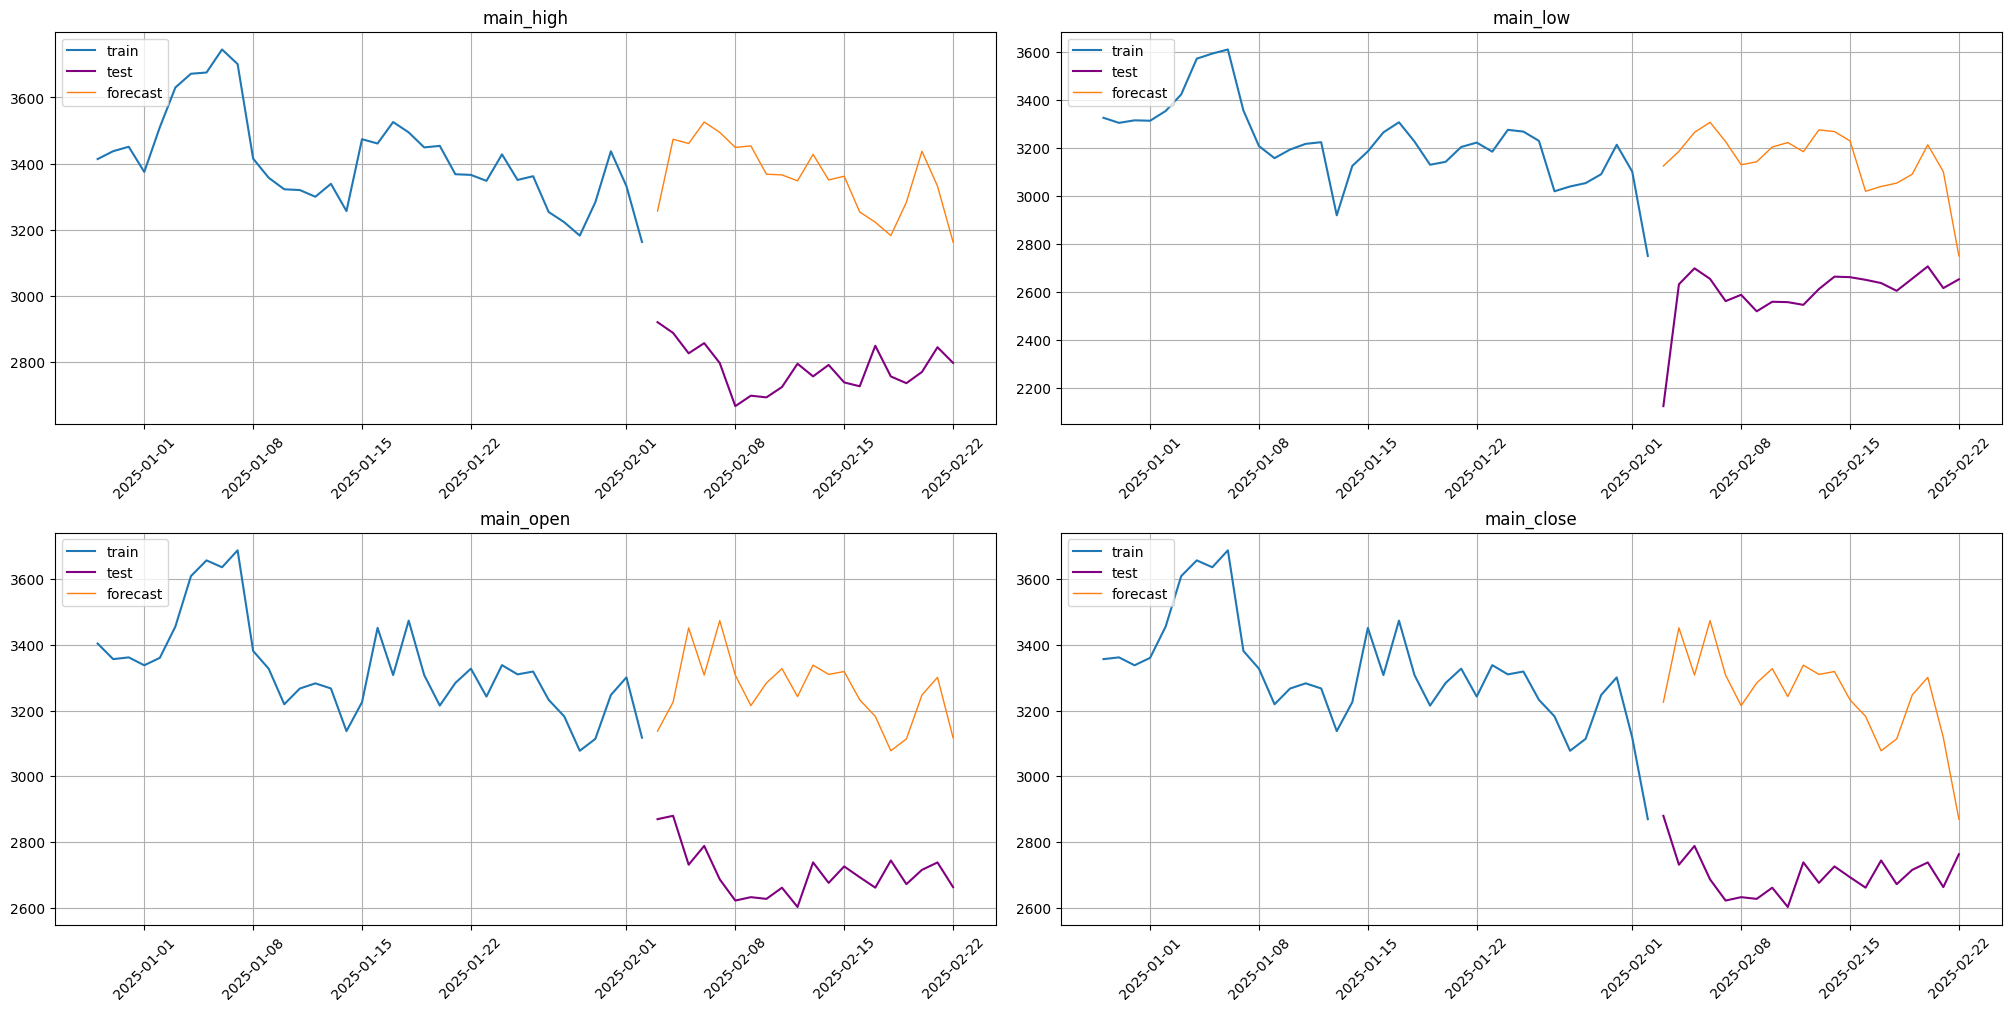

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size = 20)
HORIZON = 20
model = NaiveModel(lag=20)
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)
mape = MAPE()
print(mape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=36)

In [ ]:
ts

segment         main_close                                                \
feature    close_BTC_lag_1 close_BTC_lag_2 diff_ETH_lag_1 diff_ETH_lag_2   
timestamp                                                                  
2017-08-19         4108.37         4285.08          27.85          14.18   
2017-08-20         4139.98         4108.37          21.90          27.85   
2017-08-21         4086.29         4139.98          17.68          21.90   
2017-08-22         4016.00         4086.29          51.92          17.68   
2017-08-23         4040.00         4016.00         186.20          51.92   
...                    ...             ...            ...            ...   
2025-02-18        95780.00        96118.12         211.99          76.05   
2025-02-19        95671.74        95780.00         151.49         211.99   
2025-02-20        96644.37        95671.74          80.67         151.49   
2025-02-21        98305.00        96644.37          63.41          80.67   
2025-02-22        96181.98        98305.00         228.60          63.41   

segment                                                               \
feature    high_BTC_lag_1 high_BTC_lag_2 low_BTC_lag_1 low_BTC_lag_2   
timestamp                                                              
2017-08-19        4371.52        4485.39       3938.77       4200.74   
2017-08-20        4184.69        4371.52       3850.00       3938.77   
2017-08-21        4211.08        4184.69       4032.62       3850.00   
2017-08-22        4119.62        4211.08       3911.79       4032.62   
2017-08-23        4104.82        4119.62       3400.00       3911.79   
...                   ...            ...           ...           ...   
2025-02-18       97046.59       97704.47      95205.00      96046.18   
2025-02-19       96753.91       97046.59      93388.09      95205.00   
2025-02-20       96899.99       96753.91      95029.99      93388.09   
2025-02-21       98711.36       96899.99      96415.09      95029.99   
2025-02-22       99475.00       98711.36      94871.95      96415.09   

segment                                   ...      main_open                \
feature    open_BTC_lag_1 open_BTC_lag_2  ... high_BTC_lag_2 low_BTC_lag_1   
timestamp                                 ...                                
2017-08-19        4285.08        4261.48  ...        4485.39       3938.77   
2017-08-20        4108.37        4285.08  ...        4371.52       3850.00   
2017-08-21        4120.98        4108.37  ...        4184.69       4032.62   
2017-08-22        4069.13        4120.98  ...        4211.08       3911.79   
2017-08-23        4016.00        4069.13  ...        4119.62       3400.00   
...                   ...            ...  ...            ...           ...   
2025-02-18       96118.12       97569.67  ...       97704.47      95205.00   
2025-02-19       95780.01       96118.12  ...       97046.59      93388.09   
2025-02-20       95671.74       95780.01  ...       96753.91      95029.99   
2025-02-21       96644.37       95671.74  ...       96899.99      96415.09   
2025-02-22       98305.01       96644.37  ...       98711.36      94871.95   

segment                                                          \
feature    low_BTC_lag_2 open_BTC_lag_1 open_BTC_lag_2   target   
timestamp                                                         
2017-08-19       4200.74        4285.08        4261.48   293.31   
2017-08-20       3938.77        4108.37        4285.08   289.41   
2017-08-21       3850.00        4120.98        4108.37   299.10   
2017-08-22       4032.62        4069.13        4120.98   321.04   
2017-08-23       3911.79        4016.00        4069.13   312.25   
...                  ...            ...            ...      ...   
2025-02-18      96046.18       96118.12       97569.67  2744.05   
2025-02-19      95205.00       95780.01       96118.12  2672.00   
2025-02-20      93388.09       95671.74       95780.01  2715.51   
2025-02-21      95029.99     

[LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ),
 STLTransform(in_column = 'target', period = 10, model = 'arima', robust = True, model_kwargs = None, stl_kwargs = None, ),
 ChangePointsTrendTransform(in_column = 'target', change_points_model = RupturesChangePointsModel(change_points_model = <ruptures.detection.binseg.Binseg object at 0x7c4fb6a25710>, n_bkps = 5, ), per_interval_model = SklearnRegressionPerIntervalModel(model = LinearRegression(), ), ),
 LagTransform(in_column = 'target', lags = [20, 21, 22], out_column = 'lag', ),
 StdTransform(in_column = 'lag_20', window = 7, seasonality = 1, min_periods = 1, fillna = 0, out_column = 'std', ddof = 1, ),
 MeanTransform(in_column = 'lag_20', window = 7, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean', )]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   40.5s
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   16.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   21.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   21.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | el


MAPE_avg (20,)
close:  7.270853362034437
high:  7.145026807533395
low:  8.05060109679491
open:  7.7912897427604975
AVG_metrics:  7.56444275228081


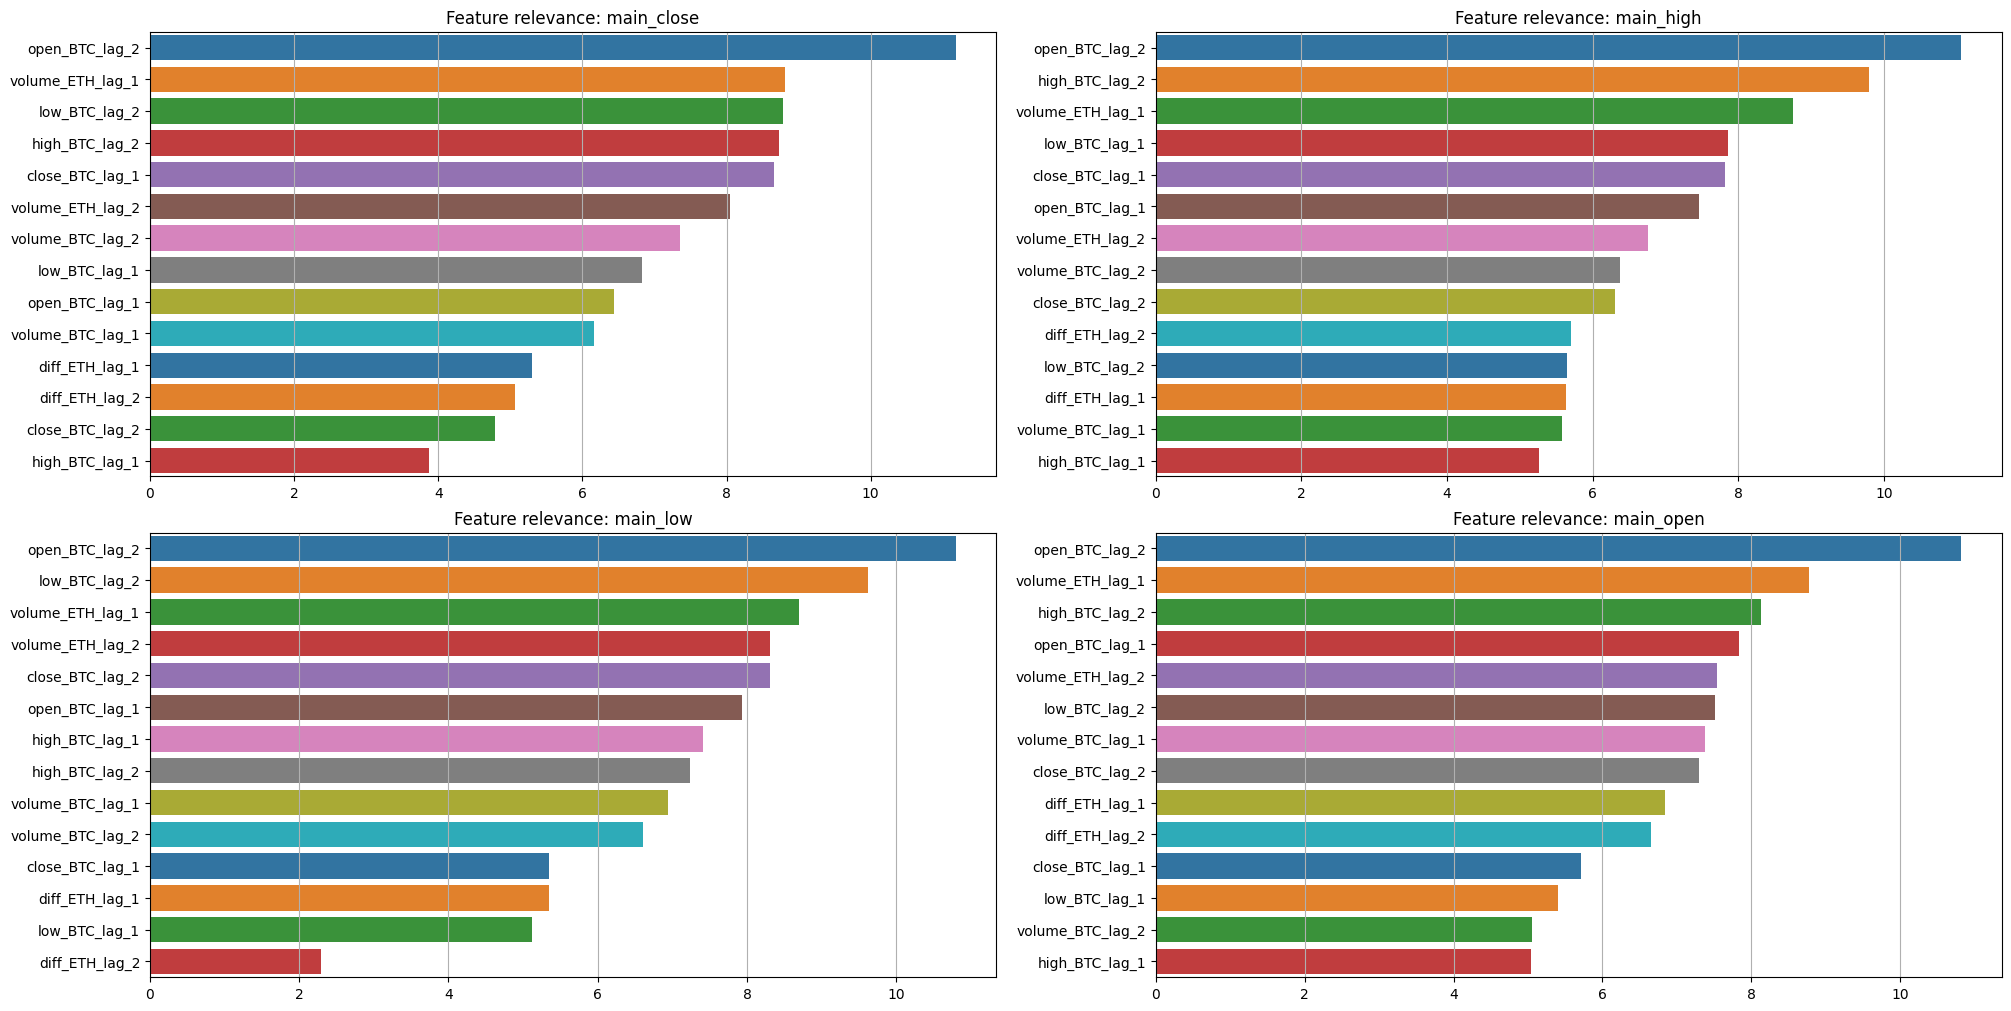

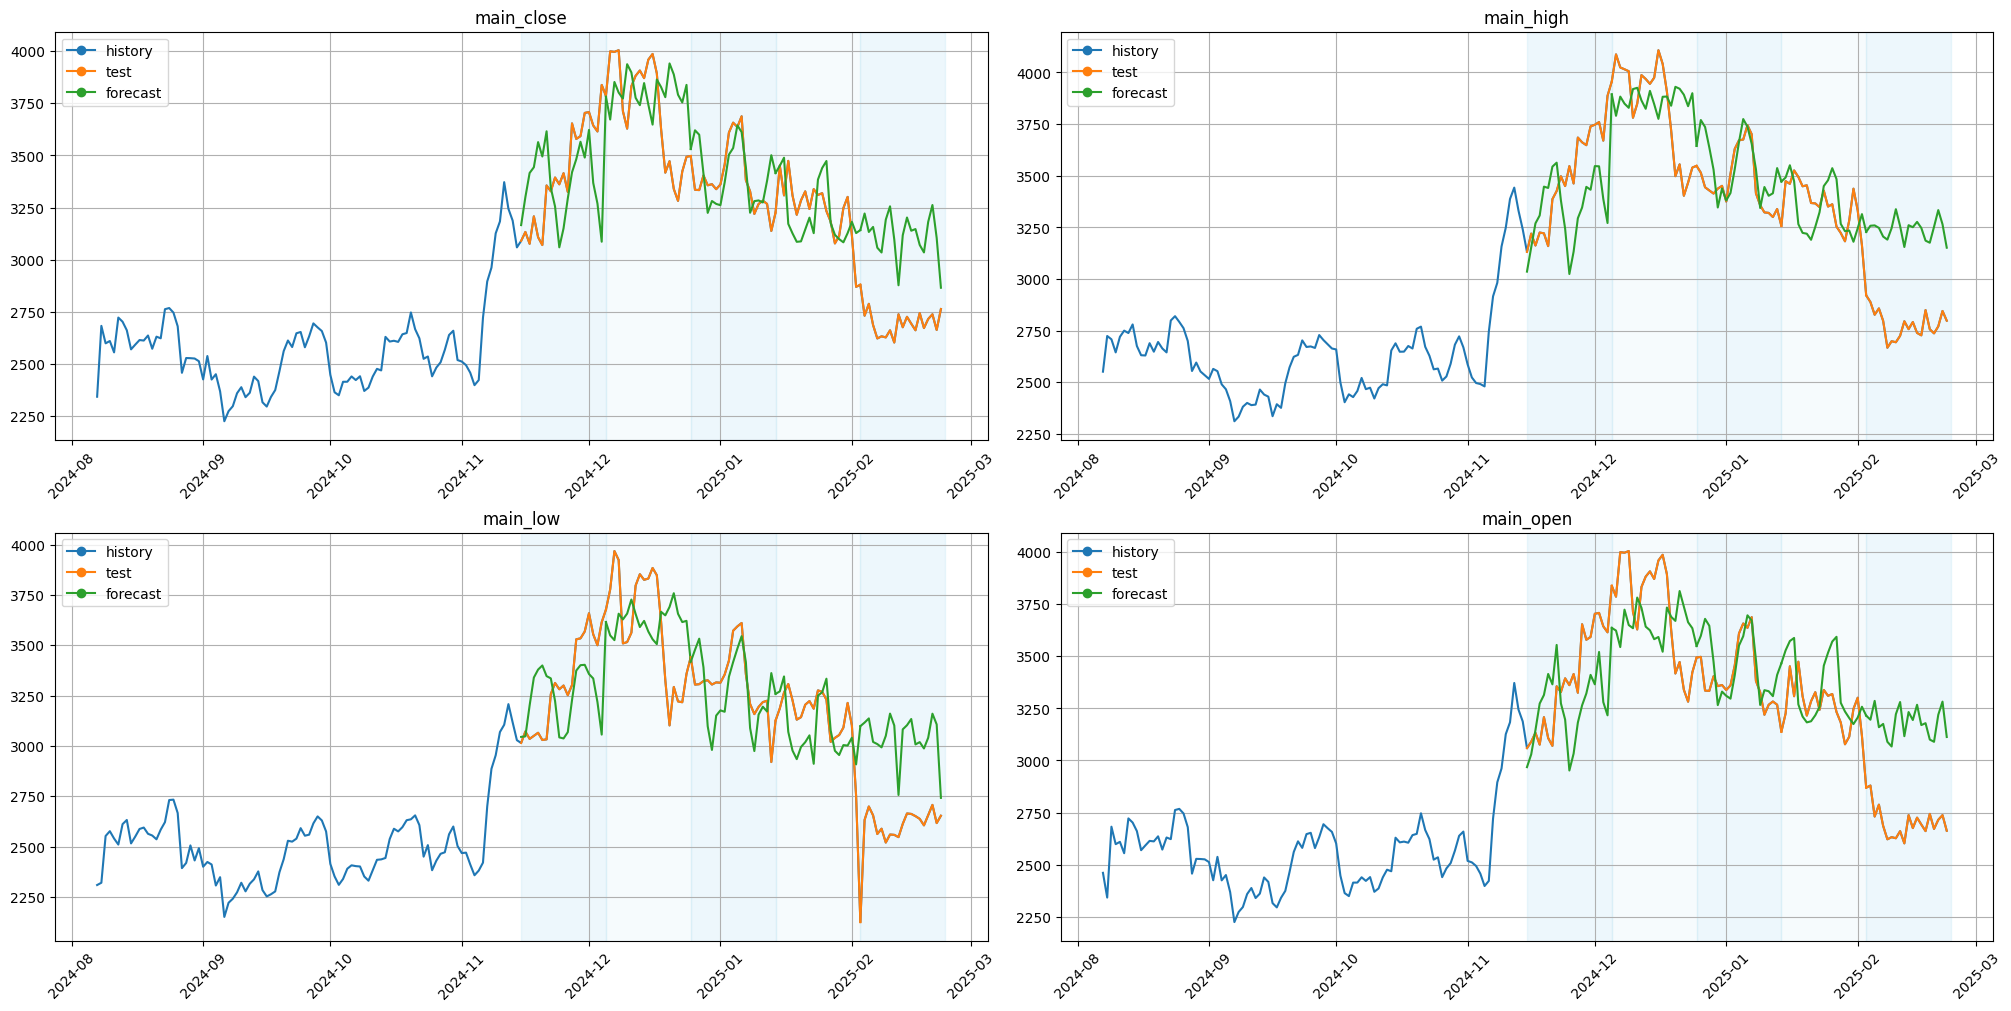

In [ ]:
from etna.transforms import (
    ChangePointsLevelTransform,
    ChangePointsTrendTransform,
    DifferencingTransform,
    LagTransform,
    TheilSenTrendTransform,
    StdTransform,
    MinTransform,
    MaxTransform
)
from etna.analysis import ModelRelevanceTable, plot_feature_relevance
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

log = LogTransform(in_column="target", inplace=True)
stl = STLTransform(
    in_column = "target",
    period = 10,
    robust = True
)
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 23)), out_column="lag")
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=7, out_column="mean")
std = StdTransform(in_column=f"lag_{HORIZON}", window=7, out_column="std")
CPTI = ChangePointsTrendTransform(in_column="target")
transforms = [log, stl, CPTI, lags, std, mean]
display(transforms)
print()

model = CatBoostMultiSegmentModel(
  iterations=500,
  learning_rate=0.01,
  depth=8,
  loss_function='MAPE',
)
pipeline = Pipeline(model=model, horizon=HORIZON, transforms=transforms)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MAPE()], n_folds=5)

# Отдельная модель для анализа важности признаков, тк plot_feature_relevance не робит с CatBoostMultiSegmentModel
relevance_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.01,
    depth=8,
    loss_function='MAPE',
    verbose=0
)

model_relevance_table = ModelRelevanceTable()

plot_feature_relevance(
    ts=ts,
    relevance_table=model_relevance_table,
    relevance_aggregation_mode="per-segment", # графики важности признаков для каждого сегмента
    relevance_params={"model": relevance_model},  # Используем CatBoostRegressor вместо CatBoostMultiSegmentModel
    top_k=30
)

print()
print('MAPE_avg', metrics_df.MAPE.shape)
print('close: ', metrics_df.MAPE.iloc[:5].mean())
print('high: ', metrics_df.MAPE.iloc[5:10].mean())
print('low: ', metrics_df.MAPE.iloc[10:15].mean())
print('open: ', metrics_df.MAPE.iloc[15:20].mean())
print('AVG_metrics: ', metrics_df.MAPE.mean())

plot_backtest(forecast_df, ts, history_len=100)

##Создание общего датасета

### ФРС - центральный банк США

In [ ]:
import pandas_datareader as pdr
from datetime import datetime

# Загрузка ставки ФРС
start_date = datetime(2017, 8, 20)
end_date = datetime(2025, 3, 14)
fed_rate = pdr.get_data_fred('FEDFUNDS', start_date, end_date)

full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
fed_rate_daily = fed_rate.reindex(full_date_range).ffill()
fed_rate_daily = fed_rate_daily[12:]
fed_rate_daily = fed_rate_daily.reset_index()
fed_rate_daily = fed_rate_daily.rename(columns={'index':'timestamp'})
fed_rate_daily["timestamp"] = pd.to_datetime(fed_rate_daily["timestamp"], unit="s")
fed_rate_daily['FEDFUNDS_lag_1'] = fed_rate_daily['FEDFUNDS'].shift(1)
fed_rate_daily = fed_rate_daily.drop('FEDFUNDS', axis = 1)
fed_rate_daily = fed_rate_daily[1:]
display(fed_rate_daily)

timestamp  FEDFUNDS_lag_1
1    2017-09-02            1.15
2    2017-09-03            1.15
3    2017-09-04            1.15
4    2017-09-05            1.15
5    2017-09-06            1.15
...         ...             ...
2747 2025-03-10            4.33
2748 2025-03-11            4.33
2749 2025-03-12            4.33
2750 2025-03-13            4.33
2751 2025-03-14            4.33

[2751 rows x 2 columns]

### CPI PPI индексы

CPI — индекс потребительских цен.  
PPI — индекс цен производителей.

In [ ]:
from pandas_datareader import data as pdr
import datetime

start_date = datetime.datetime(2017, 8, 25)
end_date = datetime.datetime(2025, 3, 14)
cpi = pdr.get_data_fred('CPIAUCSL', start_date, end_date)  # Monthly CPI for All Urban Consumers
cpi = cpi.rename(columns={'CPIAUCSL': 'CPI'})
ppi = pdr.get_data_fred('PPIACO', start_date, end_date)  # Monthly PPI for All Commodities
ppi = ppi.rename(columns={'PPIACO': 'PPI'})
macro_data = pd.concat([cpi, ppi], axis=1)
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
macro_data = macro_data.reindex(full_date_range).ffill().reset_index()
macro_data = macro_data.rename(columns={'index': 'timestamp'})
macro_data["timestamp"] = pd.to_datetime(macro_data["timestamp"], unit="s")
macro_data['CPI_lag_1'] = macro_data['CPI'].shift(1)
macro_data['PPI_lag_1'] = macro_data['PPI'].shift(1)
macro_data = macro_data.drop(['CPI', 'PPI'], axis = 1)
macro_data = macro_data[8:]
macro_data

timestamp  CPI_lag_1  PPI_lag_1
8    2017-09-02    246.435    194.800
9    2017-09-03    246.435    194.800
10   2017-09-04    246.435    194.800
11   2017-09-05    246.435    194.800
12   2017-09-06    246.435    194.800
...         ...        ...        ...
2754 2025-03-10    319.615    258.837
2755 2025-03-11    319.615    258.837
2756 2025-03-12    319.615    258.837
2757 2025-03-13    319.615    258.837
2758 2025-03-14    319.615    258.837

[2751 rows x 3 columns]

### Уровень риска/осторожности

In [ ]:
import requests
import pandas as pd

def get_fear_greed_index(days=365):
    url = "https://api.alternative.me/fng/?limit=" + str(days)
    data = requests.get(url).json()["data"]
    df = pd.DataFrame(data)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df = df.loc[:, ['value', 'timestamp']]
    df = df.sort_values('timestamp')
    df = df[df['timestamp'] <= '2025-03-14']
    df= df.reset_index(drop = True)
    df = df.rename(columns={'value': 'fear'})
    df['fear_lag_1'] = df['fear'].shift(1)
    df = df.drop('fear', axis = 1)
    df = df[1:]
    return df

fg_index = get_fear_greed_index(3000)
fg_index

<ipython-input-54-100a5e8c1cc2>:8: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")


timestamp fear_lag_1
1    2018-02-02         30
2    2018-02-03         15
3    2018-02-04         40
4    2018-02-05         24
5    2018-02-06         11
...         ...        ...
2590 2025-03-10         27
2591 2025-03-11         20
2592 2025-03-12         24
2593 2025-03-13         34
2594 2025-03-14         45

[2594 rows x 2 columns]

### Добавление признаков

TOTAL в контексте криптовалют — это индекс, который отображает общую рыночную капитализацию всех криптовалют.  
Существуют разные виды индексов TOTAL, например:  
TOTAL1 — самый общий индекс, показывает общее состояние рынка. По нему можно судить, растёт или падает весь рынок криптовалют.  
TOTAL2 — индекс, который показывает общую рыночную капитализацию всех криптовалют, исключая из расчёта Bitcoin (BTC). Позволяет оценить, как ведут себя альткоины, не завися от доминирования BTC.  
TOTAL3 — индекс, который исключает из расчёта капитализацию двух основных криптовалют — Bitcoin (BTC) и Ethereum (ETH).

### Тотал для ETH

In [ ]:
import yfinance as yf
import pandas as pd

# Для Ethereum (ETH-USD)
eth_data = yf.download("ETH-USD", start="2017-08-20", end="2025-03-14")
eth_market_cap = eth_data['Close'] * eth_data['Volume']  # Примерная капитализация

# Создаем полный диапазон дат
full_date_range = pd.date_range(start="2017-08-20", end="2025-03-14", freq='D')
eth_market_cap_full = eth_market_cap.reindex(full_date_range)
eth_market_cap_full = eth_market_cap_full.ffill()
eth_market_cap_full = eth_market_cap_full[81:]
eth_market_cap_full = eth_market_cap_full.rename(columns={'ETH-USD': 'TOTAL_ETH'})
eth_market_cap_full = eth_market_cap_full.reset_index()
eth_market_cap_full = eth_market_cap_full.rename(columns={'index': 'timestamp'})
eth_market_cap_full['timestamp'] = pd.to_datetime(eth_market_cap_full['timestamp'])
TOTAL_ETH = eth_market_cap_full.copy()

[*********************100%***********************]  1 of 1 completed


### Создание признаков с помощью yf

DXY - индекс доллара США в зависимости от других валют.  
GSP - Индекс S&P 500. индекс акций 500 корпораций.  
IXIC -  включает в себя более 3000 ценных бумаг.  
Gold - цена золотишка по фьючерсам.  
Oil Brent -цена нефти Brent по фьючерсам.  
TNX -  индекс 10-летней доходности государственных облигаций.  
IRX - во сколько раз прибыль до уплаты процентов и налогов превышает расходы на уплату процентов.  
Oil_WIT - цена нефти WIT по фьючерсам.  


In [ ]:
import yfinance as yf
import pandas as pd

start_date = "2017-08-20"
end_date = "2025-03-14"

def create_data(tickers: list, name_data: list):
    merged_df = None
    for i in range(len(tickers)):
        df = yf.download(tickers[i], start=start_date, end=end_date)
        full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        df = df.reindex(full_date_range)
        df = df.ffill()
        df.columns = df.columns.droplevel(1)

        df = df.reset_index()
        df = df.rename(columns={'index': 'timestamp', 'Open': name_data[i]})
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.drop(['Close', 'High', 'Low', 'Volume'], axis = 1)
        df[f'{name_data[i]}_lag_1'] = df[name_data[i]].shift(1)
        df = df.drop(name_data[i], axis = 1)
        df = df[2:]
        df
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='timestamp', how='inner')
    return merged_df

In [ ]:
tickers = ['DX-Y.NYB', '^GSPC', '^IXIC', 'GC=F', 'BZ=F', '^TNX', '^IRX']
names = ['DXY', 'GSPC', 'IXIC', 'Gold', 'Oil_Brent', 'TNX', 'IRX']
dataframe_yf = create_data(tickers, names)
dataframe_yf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price  timestamp   DXY_lag_1   GSPC_lag_1    IXIC_lag_1   Gold_lag_1  \
0     2017-08-22   93.430000  2425.500000   6216.319824  1285.199951   
1     2017-08-23   93.139999  2433.750000   6241.209961  1287.199951   
2     2017-08-24   93.510002  2444.879883   6263.470215  1289.400024   
3     2017-08-25   93.160004  2447.909912   6294.819824  1288.699951   
4     2017-08-26   93.269997  2444.719971   6293.810059  1285.400024   
...          ...         ...          ...           ...          ...   
2757  2025-03-10  104.110001  5726.009766  18029.849609  2900.899902   
2758  2025-03-11  103.910004  5705.370117  17840.320312  2910.100098   
2759  2025-03-12  103.839996  5603.649902  17443.089844  2884.399902   
2760  2025-03-13  103.419998  5624.839844  17711.410156  2912.000000   
2761  2025-03-14  103.610001  5594.450195  17598.560547  2937.100098   

Price  Oil_Brent_lag_1  TNX_lag_1  IRX_lag_1  
0            52.900002      2.178      0.985  
1            51.680000      2.206      0.995  
2            51.630001      2.196      0.993  
3            52.549999      2.185      0.983  
4            52.200001      2.196      0.993  
...                ...        ...        ...  
2757         69.379997      4.251      4.188  
2758         70.440002      4.232      4.193  
2759         69.410004      4.238      4.185  
2760         69.849998      4.309      4.197  
2761         70.980003      4.330      4.193  

[2762 rows x 8 columns]

In [ ]:
'''ticker = "^TNX"  # Тикер TNX=X на Yahoo Finance
TNX_data = yf.download(ticker, start=start_date, end=end_date) # скачиваем
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D') # Создаем полный диапазон дат от start_date до end_date
TNX_data_full = TNX_data.reindex(full_date_range) # Переиндексируем данные с полным диапазоном дат
TNX_data_full = TNX_data_full.ffill() # Заполняем пропущенные данные (выходные) методом ffill (значениями предыдущего рабочего дня)

TNX_data_full.columns = TNX_data_full.columns.droplevel(1)
TNX_data_full = TNX_data_full.reset_index()
TNX_data_full = TNX_data_full.rename(columns={'index': 'timestamp'})
TNX_data_full['timestamp'] = pd.to_datetime(TNX_data_full['timestamp'])
TNX_data_full'''

'ticker = "^TNX"  # Тикер TNX=X на Yahoo Finance\nTNX_data = yf.download(ticker, start=start_date, end=end_date) # скачиваем\nfull_date_range = pd.date_range(start=start_date, end=end_date, freq=\'D\') # Создаем полный диапазон дат от start_date до end_date\nTNX_data_full = TNX_data.reindex(full_date_range) # Переиндексируем данные с полным диапазоном дат\nTNX_data_full = TNX_data_full.ffill() # Заполняем пропущенные данные (выходные) методом ffill (значениями предыдущего рабочего дня)\n\nTNX_data_full.columns = TNX_data_full.columns.droplevel(1)\nTNX_data_full = TNX_data_full.reset_index()\nTNX_data_full = TNX_data_full.rename(columns={\'index\': \'timestamp\'})\nTNX_data_full[\'timestamp\'] = pd.to_datetime(TNX_data_full[\'timestamp\'])\nTNX_data_full'

In [ ]:
import holidays
dataframe_yf['timestamp'] = pd.to_datetime(dataframe_yf['timestamp'])
us_holidays = holidays.US()
def is_holiday(date):
    return date in us_holidays
dataframe_yf['is_holiday'] = dataframe_yf['timestamp'].apply(is_holiday).astype(int)
dataframe_yf['is_weekend'] = dataframe_yf['timestamp'].dt.dayofweek >= 5
dataframe_yf['is_holiday_or_weekend'] = (dataframe_yf['is_holiday'] | dataframe_yf['is_weekend']).astype(int)
dataframe_yf = dataframe_yf.drop(['is_holiday', 'is_weekend'], axis = 1)
display(dataframe_yf.head())

Price  timestamp  DXY_lag_1   GSPC_lag_1   IXIC_lag_1   Gold_lag_1  \
0     2017-08-22  93.430000  2425.500000  6216.319824  1285.199951   
1     2017-08-23  93.139999  2433.750000  6241.209961  1287.199951   
2     2017-08-24  93.510002  2444.879883  6263.470215  1289.400024   
3     2017-08-25  93.160004  2447.909912  6294.819824  1288.699951   
4     2017-08-26  93.269997  2444.719971  6293.810059  1285.400024   

Price  Oil_Brent_lag_1  TNX_lag_1  IRX_lag_1  is_holiday_or_weekend  
0            52.900002      2.178      0.985                      0  
1            51.680000      2.206      0.995                      0  
2            51.630001      2.196      0.993                      0  
3            52.549999      2.185      0.983                      0  
4            52.200001      2.196      0.993                      1

In [ ]:
target_df = pd.read_csv('ETHUSDT_1d.csv', delimiter=',')
regressor_df = pd.read_csv('BTCUSDT_1d.csv', delimiter=',')
# добавляем новый признак (разница между макс и мин ценой за день)
regressor_df['diff_ETH'] = target_df['high'] - target_df['low']
regressor_df = regressor_df.rename(columns={
    'open': 'open_BTC',
    'high': 'high_BTC',
    'low': 'low_BTC',
    'close': 'close_BTC',
    'volume': 'volume_BTC'
})
regressor_df['volume_ETH'] = target_df['volume']
target_df = target_df.drop('volume', axis=1)
# делаем лаги
for i in regressor_df.columns:
  if i != 'timestamp':
    regressor_df[f'{i}_lag_2'] = regressor_df[i].shift(2)
    regressor_df[f'{i}_lag_1'] = regressor_df[i].shift(1)
    regressor_df = regressor_df.drop(i, axis = 1)

# добавление новых признаков

# признак per_day
regressor_df['per_day'] = (target_df['high'] - target_df['low']) / target_df['open'] * 100
regressor_df['per_day_lag_1'] = regressor_df['per_day'].shift(1)
regressor_df = regressor_df.drop('per_day', axis = 1)
# признак category_volume
regressor_df['category_volume_lag_1'] = np.where(regressor_df['volume_ETH_lag_1'] > 1e6, 1, 0)
regressor_df['category_volume_lag_2'] = np.where(regressor_df['volume_ETH_lag_2'] > 1e6, 1, 0)

regressor_df['timestamp'] = pd.to_datetime(regressor_df['timestamp'])
regressor_df = pd.merge(regressor_df, dataframe_yf, on = 'timestamp', how = 'inner')
regressor_df = pd.merge(regressor_df, TOTAL_ETH, on = 'timestamp', how = 'inner') # добавляем TOTAL уже с шифтом
regressor_df = pd.merge(regressor_df, fg_index, on = 'timestamp', how = 'inner') # добавляем страх уже с шифтом
regressor_df = pd.merge(regressor_df, fed_rate_daily, on = 'timestamp', how = 'inner') # добавляем ставку ЦБ США уже с шифтом
regressor_df = pd.merge(regressor_df, macro_data, on = 'timestamp', how = 'inner') # добавляем CPI PPI уже с шифтом

target_df = target_df.loc[170:]
target_data = target_df.copy()
# делаем сегменты
segments = []
for feature in ['open', 'high', 'low', 'close']:
    temp = target_df[['timestamp', feature]].copy()
    temp['segment'] = f'main_{feature}'
    temp = temp.rename(columns={feature: 'target'})
    segments.append(temp)
target_df = pd.concat(segments)
# Оставляем место для прогноза на 20 дней
last_date = target_df['timestamp'].max()
cutoff_date = pd.to_datetime(last_date) - pd.Timedelta(days=20)
target_df = target_df[pd.to_datetime(target_df['timestamp']) <= cutoff_date]
# Оставляем только нужные колонки
regressor_df = regressor_df[['timestamp'] + [col for col in regressor_df.columns if col not in ['timestamp', 'segment']]]
# Дублируем регрессоры для всех сегментов
segments_list = target_df['segment'].unique()
regressor_list = []
for segment in segments_list:
    temp = regressor_df.copy()
    temp['segment'] = segment
    regressor_list.append(temp)

regressor_df = pd.concat(regressor_list)
regressor_df_2 = regressor_df.iloc[3:].reset_index(drop = True)
regressor_df_2 = regressor_df_2.drop(['segment'], axis = 1)
ts = TSDataset(df=target_df, freq="D", df_exog=regressor_df, known_future="all")
print("Сегменты:", ts.segments)
print()
display(ts)

Сегменты: ['main_close', 'main_high', 'main_low', 'main_open']



segment    main_close                                                       \
feature     CPI_lag_1   DXY_lag_1 FEDFUNDS_lag_1   GSPC_lag_1   Gold_lag_1   
timestamp                                                                    
2018-02-03    249.529   88.639999           1.42  2808.919922  1348.500000   
2018-02-04    249.529   88.639999           1.42  2808.919922  1348.500000   
2018-02-05    249.529   88.639999           1.42  2808.919922  1348.500000   
2018-02-06    249.529   89.190002           1.42  2741.060059  1331.099976   
2018-02-07    249.529   89.660004           1.42  2614.780029  1338.199951   
...               ...         ...            ...          ...          ...   
2025-02-18    319.775  107.120003           4.33  6115.520020  2937.300049   
2025-02-19    319.775  106.820000           4.33  6121.600098  2879.199951   
2025-02-20    319.775  107.029999           4.33  6117.759766  2938.699951   
2025-02-21    319.775  107.120003           4.33  6134.500000  2949.100098   
2025-02-22    319.775  106.459999           4.33  6114.100098  2938.800049   

segment                                                                 ...  \
feature    IRX_lag_1    IXIC_lag_1 Oil_Brent_lag_1 PPI_lag_1 TNX_lag_1  ...   
timestamp                                                               ...   
2018-02-03     1.445   7347.589844       69.750000   199.300     2.786  ...   
2018-02-04     1.445   7347.589844       69.750000   199.300     2.786  ...   
2018-02-05     1.445   7347.589844       69.750000   199.300     2.786  ...   
2018-02-06     1.445   7165.959961       68.199997   199.300     2.834  ...   
2018-02-07     1.498   6837.560059       66.989998   199.300     2.738  ...   
...              ...           ...             ...       ...       ...  ...   
2025-02-18     4.210  19956.820312       75.239998   259.805     4.531  ...   
2025-02-19     4.213  20090.550781       74.639999   259.805     4.519  ...   
2025-02-20     4.220  19994.500000       75.800003   259.805     4.566  ...   
2025-02-21     4.210  20029.189453       76.040001   259.805     4.507  ...   
2025-02-22     4.200  20006.689453       76.559998   259.805     4.484  ...   

segment        main_open                                              \
feature    low_BTC_lag_1 low_BTC_lag_2 open_BTC_lag_1 open_BTC_lag_2   
timestamp                                                              
2018-02-03       8010.02       8750.99        9224.52       10285.10   
2018-02-04       8229.00       8010.02        8873.03        9224.52   
2018-02-05       7930.00       8229.00        9199.96        8873.03   
2018-02-06       6625.00       7930.00        8179.99        9199.96   
2018-02-07       6000.01       6625.00        6939.63        8179.99   
...                  ...           ...            ...            ...   
2025-02-18      95205.00      96046.18       96118.12       97569.67   
2025-02-19      93388.09      95205.00       95780.01       96118.12   
2025-02-20      95029.99      93388.09       95671.74       95780.01   
2025-02-21      96415.09      95029.99       96644.37       95671.74   
2025-02-22      94871.95      96415.09       98305.01       96644.37   

segment                                                              \
feature    per_day_lag_1   target volume_BTC_lag_1 volume_BTC_lag_2   
timestamp                                                             
2018-02-03     25.293457   923.67     49971.626975     33564.764311   
2018-02-04     15.914775   971.00     28725.000735     49971.626975   
2018-02-05     19.155510   821.60     32014.308449     28725.000735   
2018-02-06     27.693525   697.93     63403.182579     32014.308449   
2018-02-07     32.653705   779.99    100201.500307     63403.182579   
...                  ...      ...              ...              ...   
2025-02-18      7.965327  2744.05     16492.045100      8191.424900   
2025-02-19      5.520672  2672.00     23368.194710     16492.045100   
2025-02-20

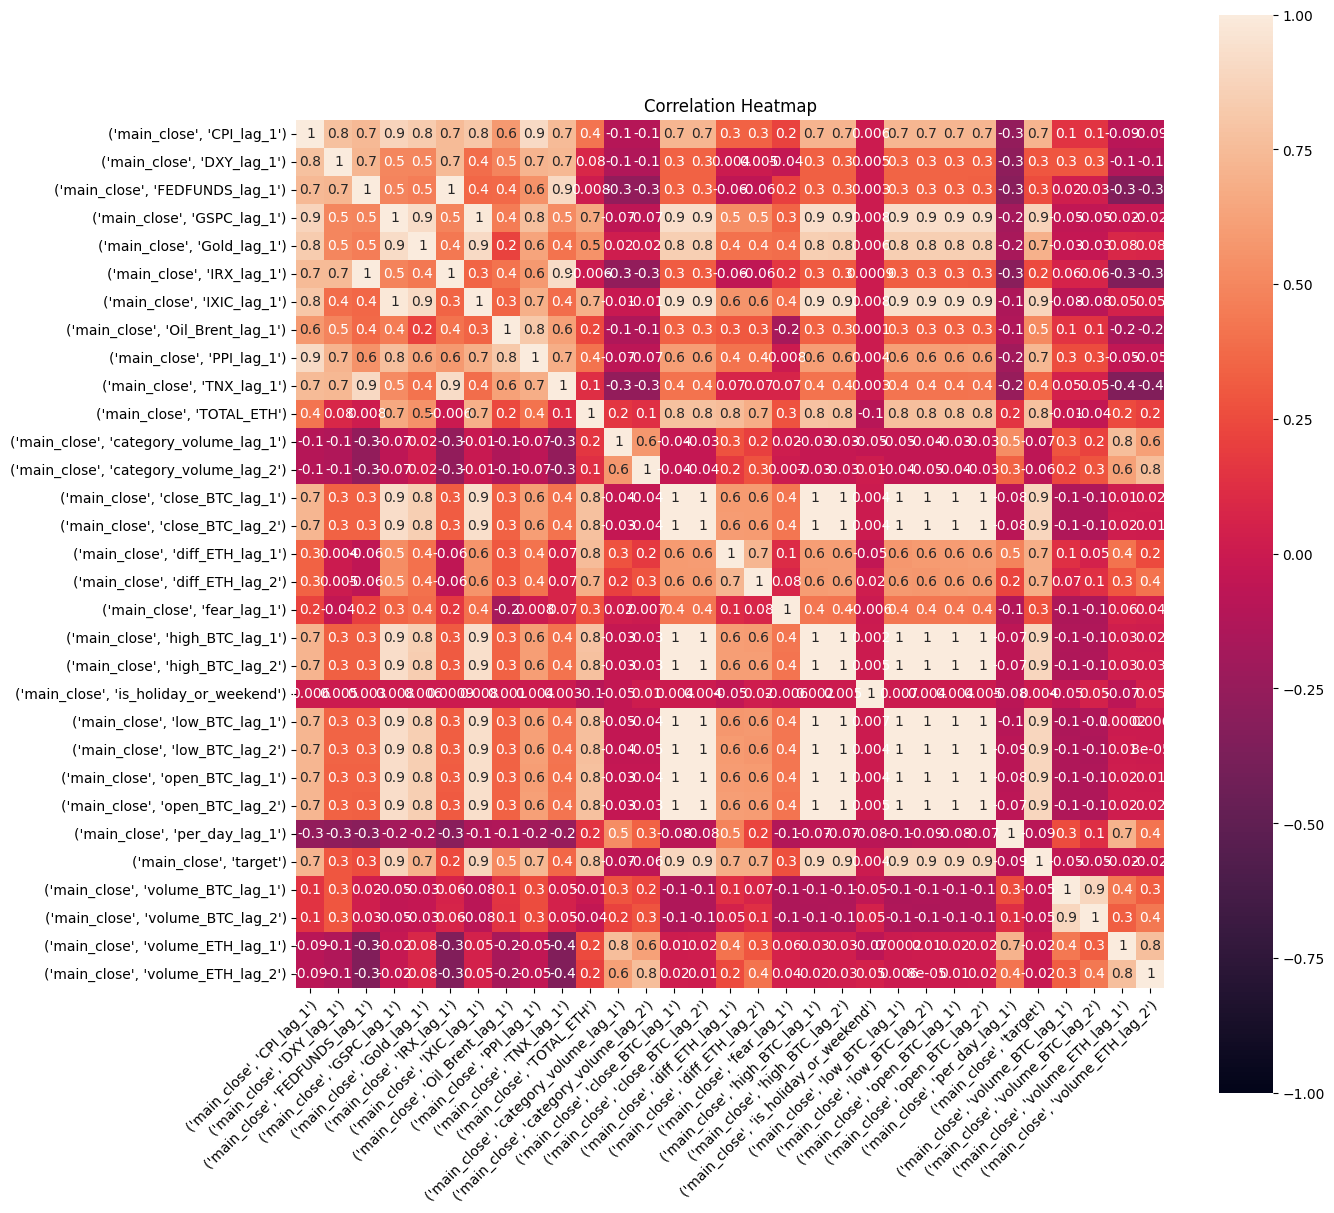

In [ ]:
plot_correlation_matrix(ts, method = 'pearson', figsize = [14, 14], segments = 'main_close')
# mode = 'macro' не воркает, ъотя должно строить все 4 графика в одном с усреднением метрик
# plot_correlation_matrix(ts, method = 'pearson', mode = 'macro', figsize = [12, 12], segments = 'main_close')

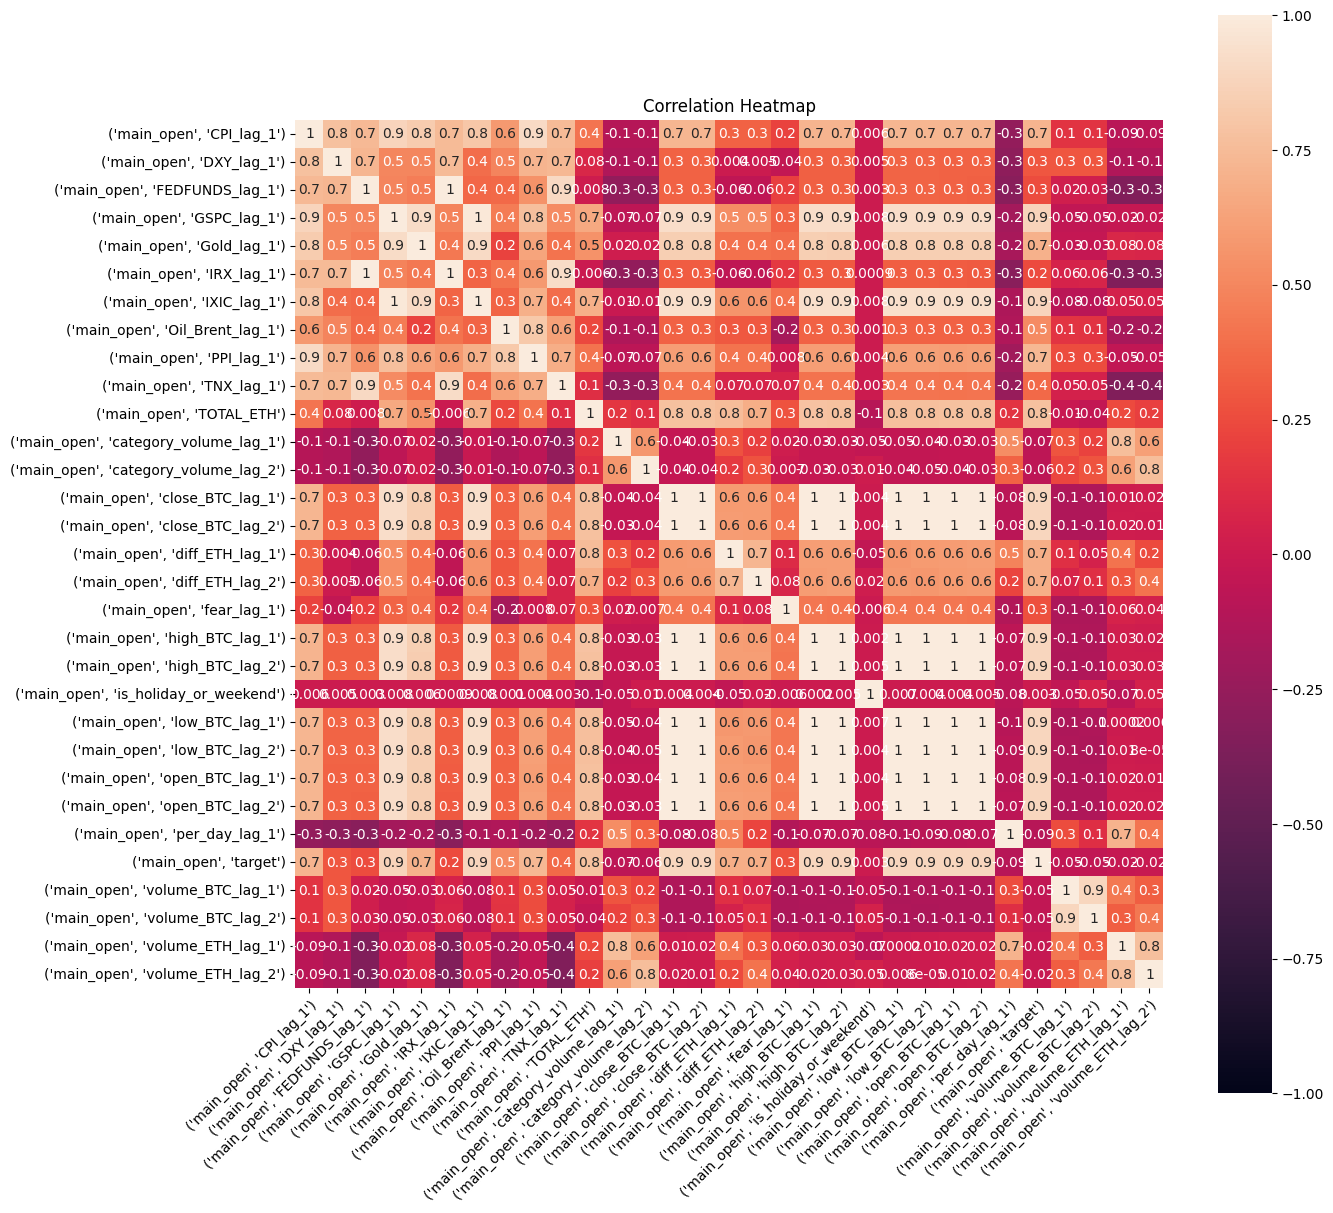

In [ ]:
plot_correlation_matrix(ts, method = 'pearson', figsize = [14, 14], segments = 'main_open')

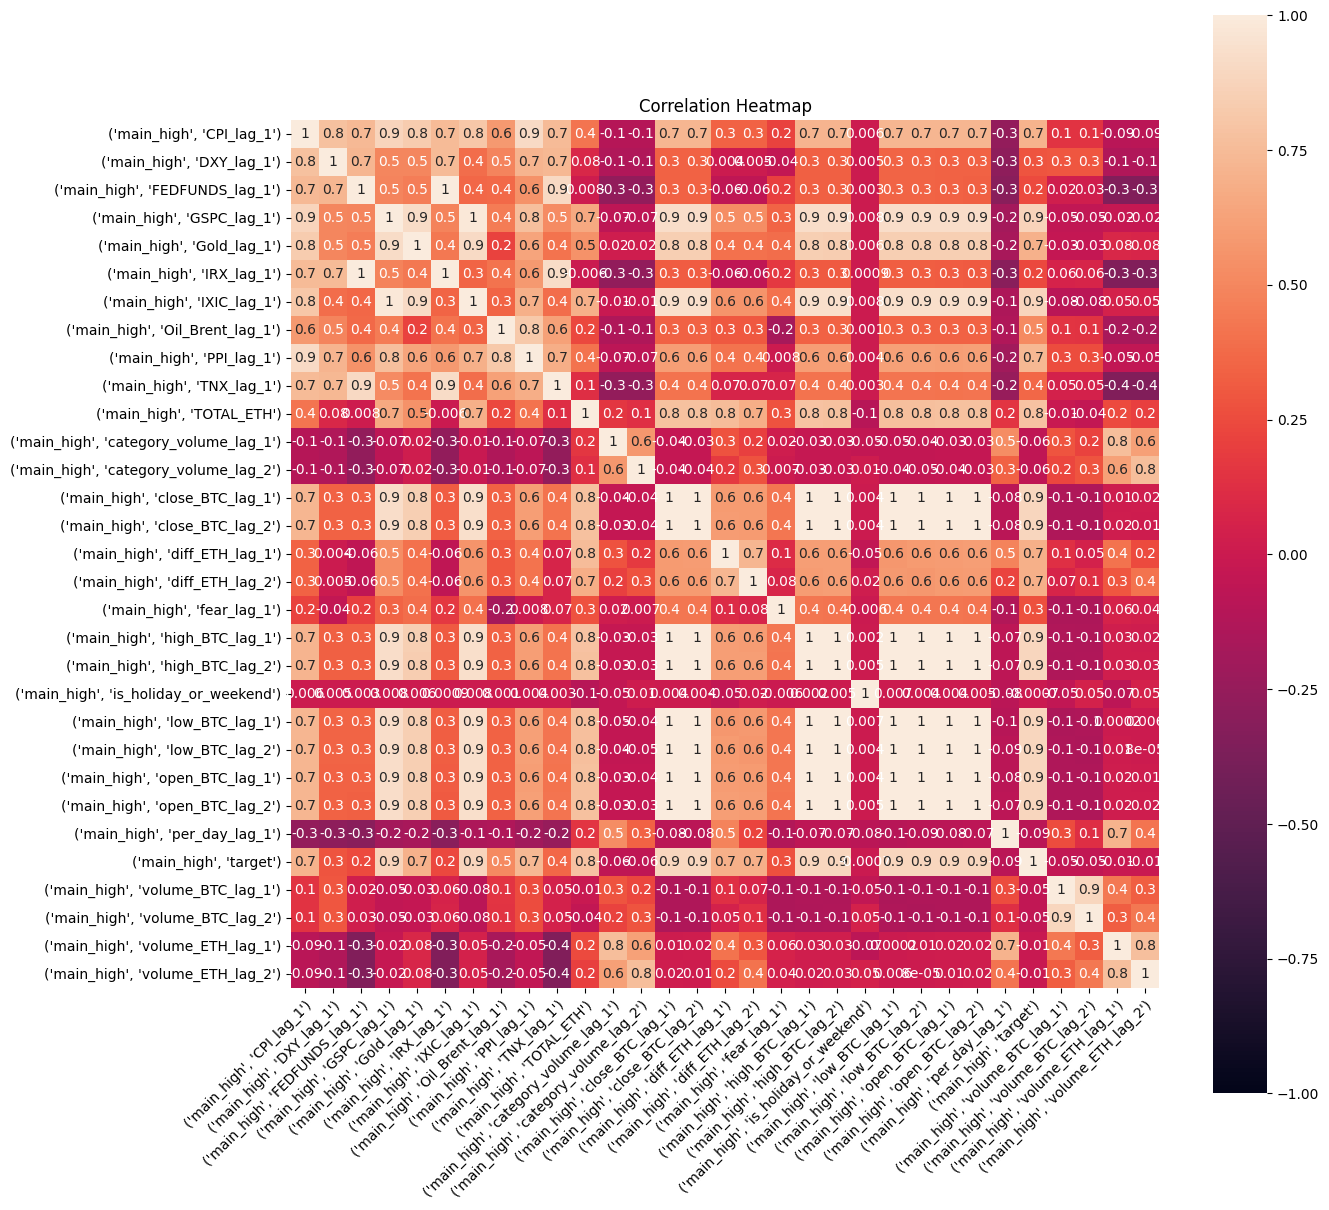

In [ ]:
plot_correlation_matrix(ts, method = 'pearson', figsize = [14, 14], segments = 'main_high')

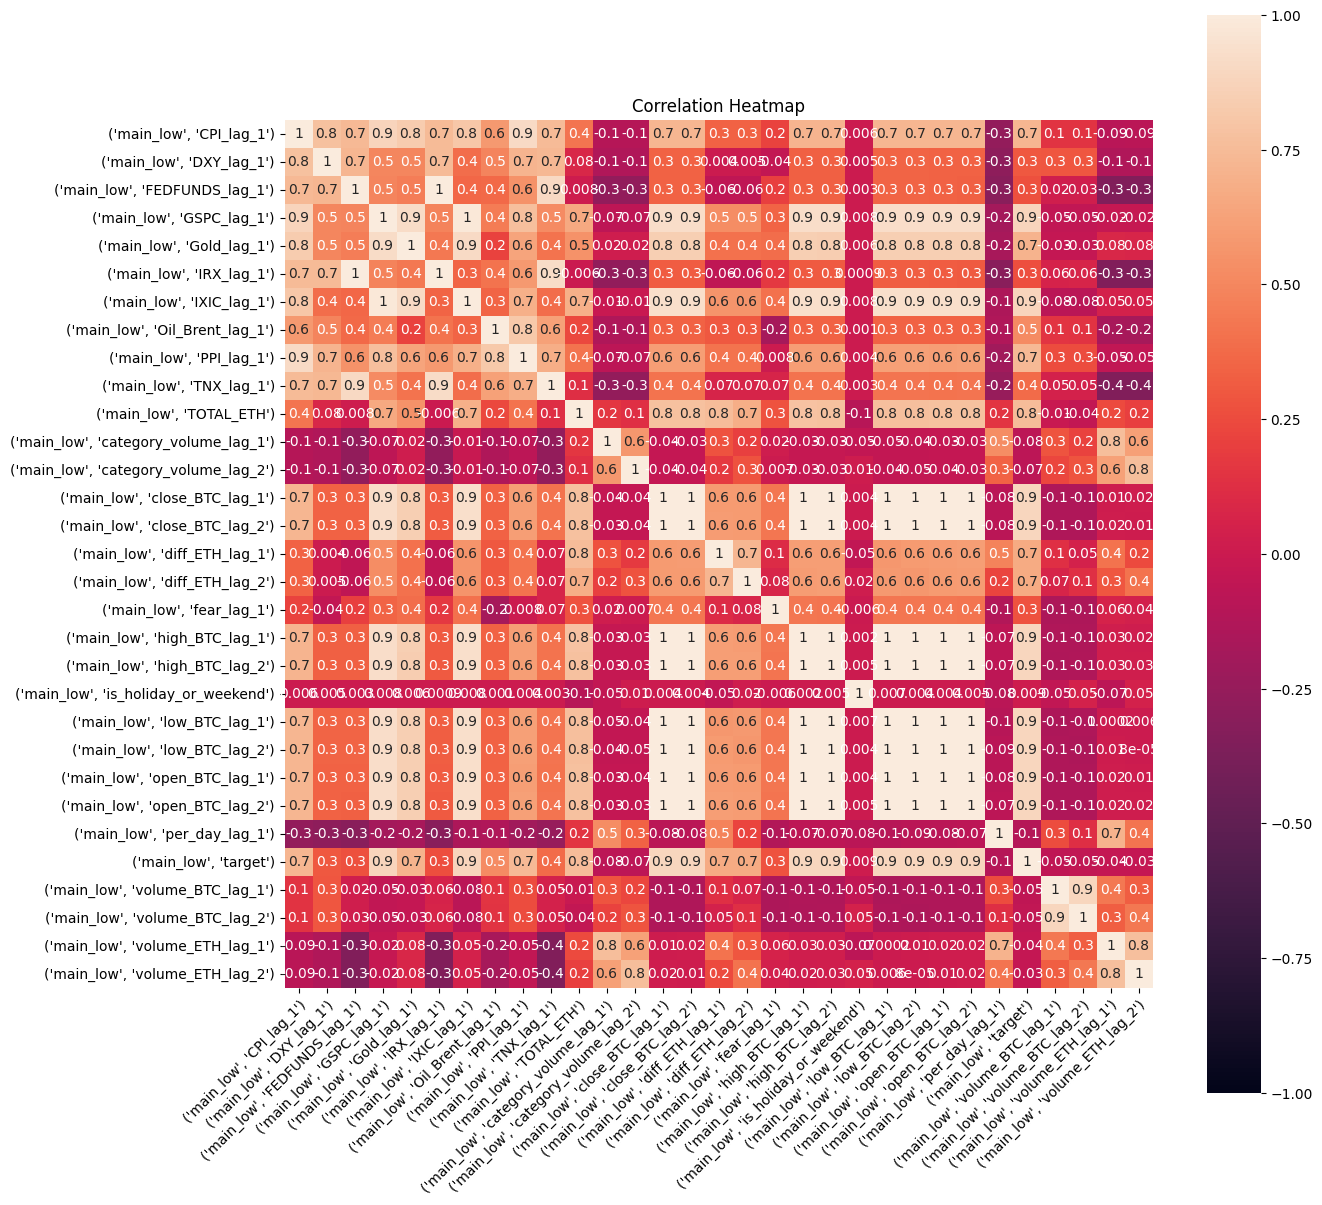

In [ ]:
plot_correlation_matrix(ts, method = 'pearson', figsize = [14, 14], segments = 'main_low')

[LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ),
 STLTransform(in_column = 'target', period = 10, model = 'arima', robust = True, model_kwargs = None, stl_kwargs = None, ),
 ChangePointsTrendTransform(in_column = 'target', change_points_model = RupturesChangePointsModel(change_points_model = <ruptures.detection.binseg.Binseg object at 0x7c4fb6a25710>, n_bkps = 5, ), per_interval_model = SklearnRegressionPerIntervalModel(model = LinearRegression(), ), ),
 LagTransform(in_column = 'target', lags = [20, 21, 22], out_column = 'lag', ),
 StdTransform(in_column = 'lag_20', window = 7, seasonality = 1, min_periods = 1, fillna = 0, out_column = 'std', ddof = 1, ),
 MeanTransform(in_column = 'lag_20', window = 7, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean', )]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   26.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   52.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do


MAPE_avg (20,)
close:  7.234615918222721
high:  6.94359778269163
low:  8.055518651411571
open:  7.687825906064151
AVG_metrics:  7.480389564597519


/usr/local/lib/python3.11/dist-packages/etna/analysis/feature_relevance/relevance_table.py:33: UserWarning: Exogenous or target data contains None! It will be dropped for calculating relevance.
  warnings.warn("Exogenous or target data contains None! It will be dropped for calculating relevance.")
/usr/local/lib/python3.11/dist-packages/etna/analysis/feature_relevance/relevance_table.py:33: UserWarning: Exogenous or target data contains None! It will be dropped for calculating relevance.
  warnings.warn("Exogenous or target data contains None! It will be dropped for calculating relevance.")
/usr/local/lib/python3.11/dist-packages/etna/analysis/feature_relevance/relevance_table.py:33: UserWarning: Exogenous or target data contains None! It will be dropped for calculating relevance.
  warnings.warn("Exogenous or target data contains None! It will be dropped for calculating relevance.")
/usr/local/lib/python3.11/dist-packages/etna/analysis/feature_relevance/relevance_table.py:33: UserWarn

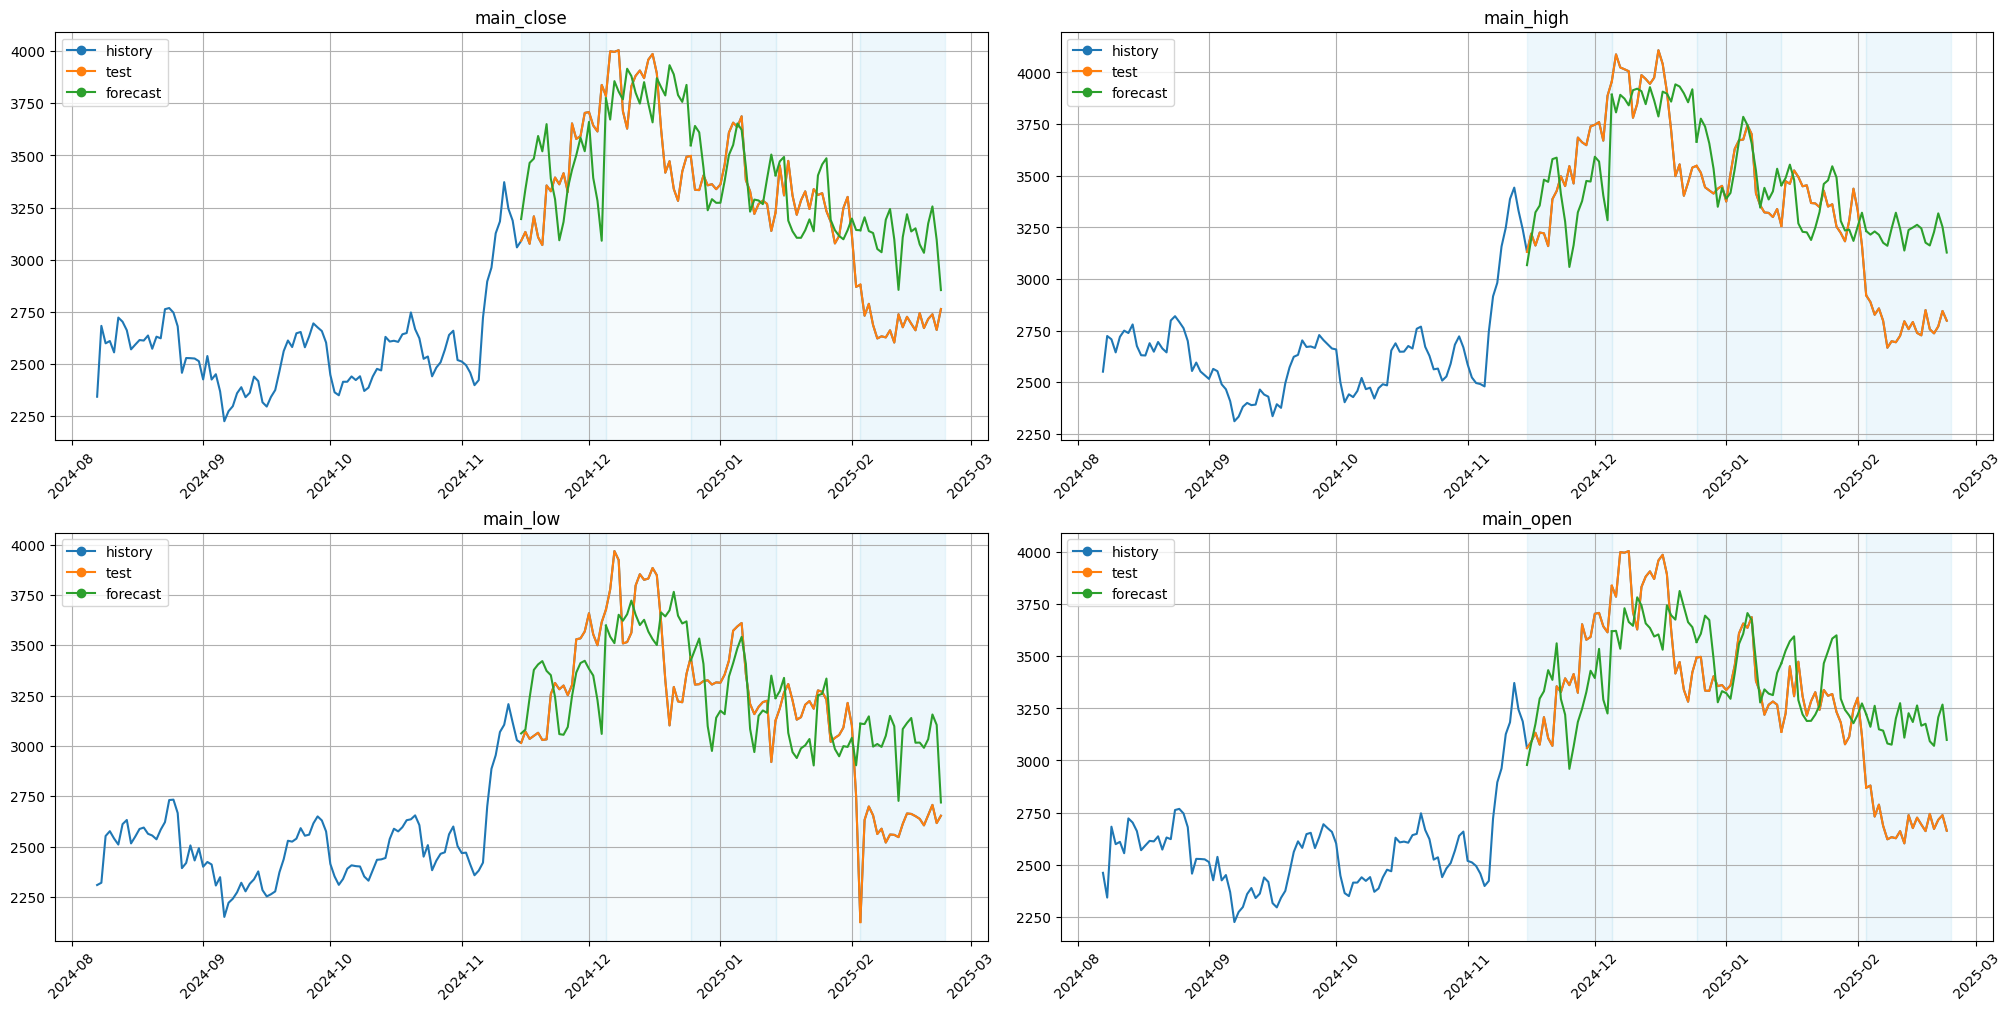

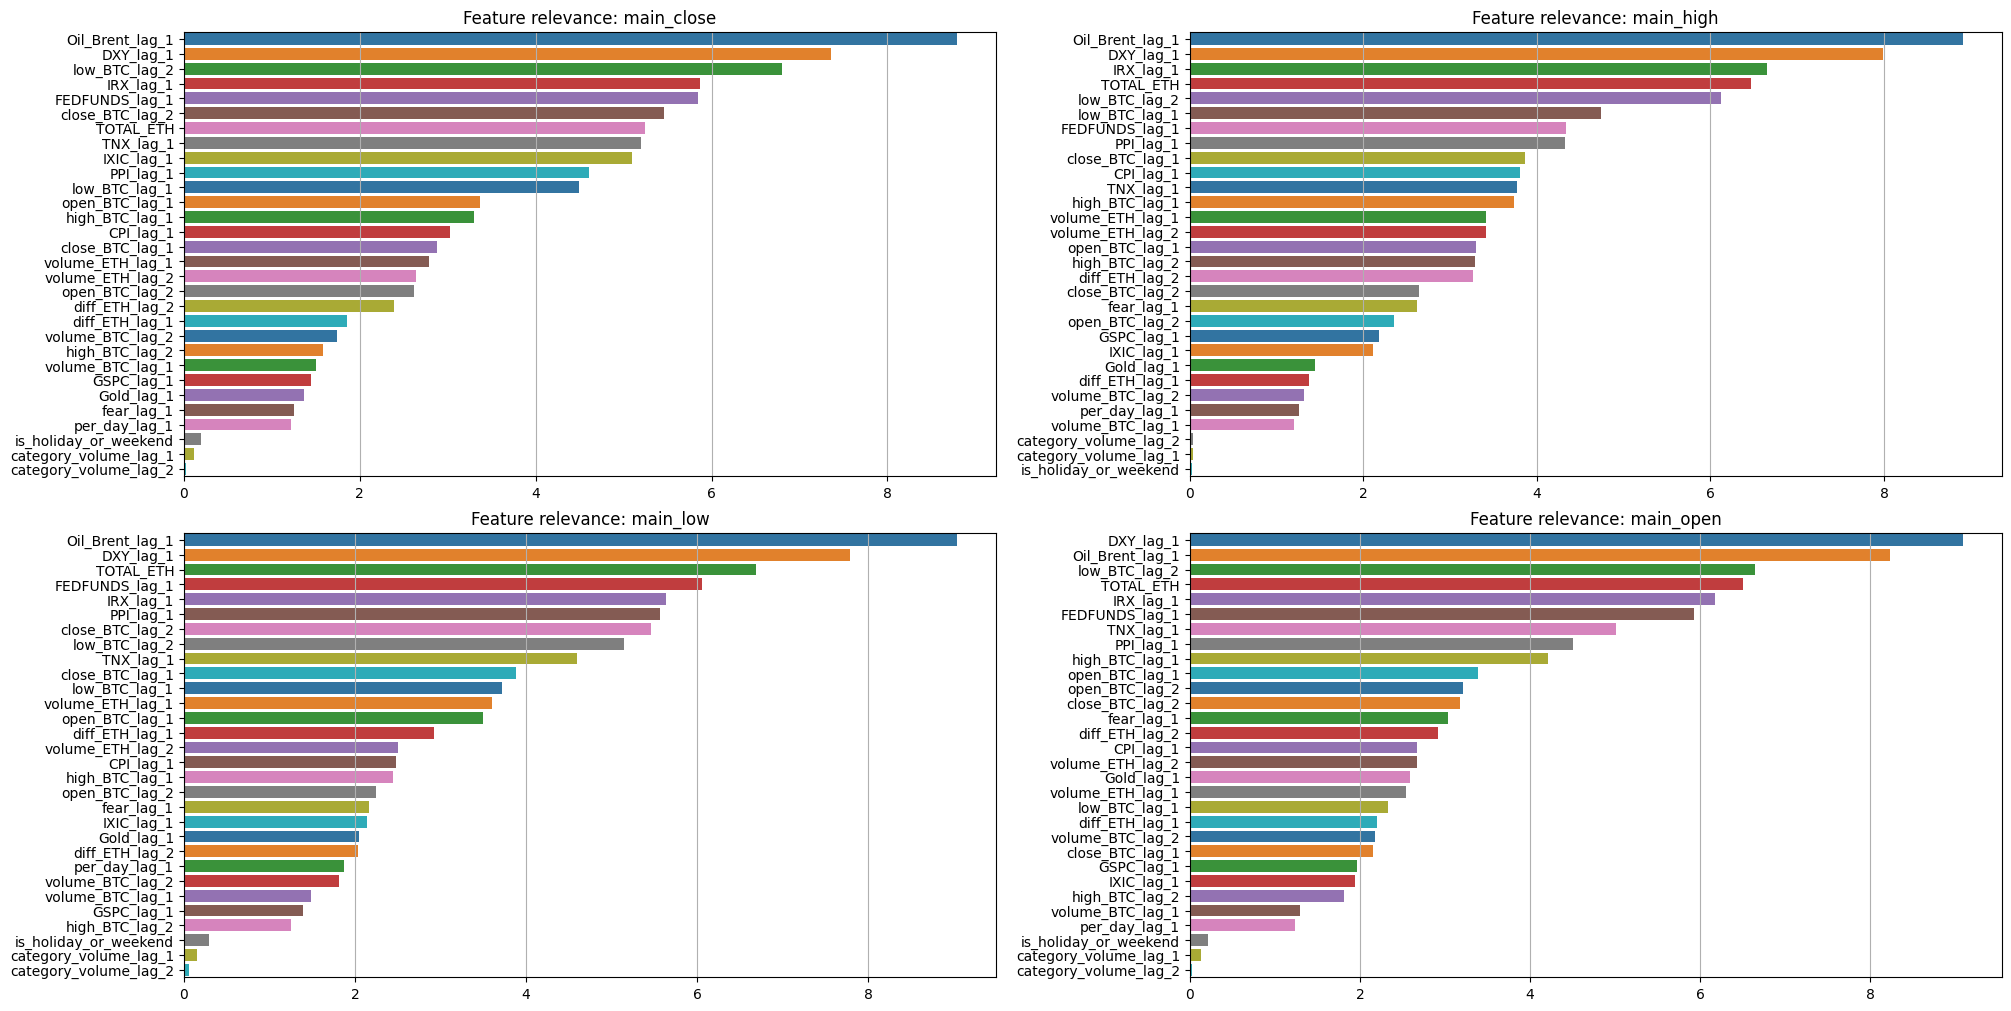

In [ ]:
from etna.transforms import (
    ChangePointsLevelTransform,
    ChangePointsTrendTransform,
    DifferencingTransform,
    LagTransform,
    TheilSenTrendTransform,
    StdTransform,
    MinTransform,
    MaxTransform
)
from etna.analysis import ModelRelevanceTable, plot_feature_relevance
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

log = LogTransform(in_column="target", inplace=True)
stl = STLTransform(
    in_column = "target",
    period = 10,
    robust = True
)
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 23)), out_column="lag")
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=7, out_column="mean")
std = StdTransform(in_column=f"lag_{HORIZON}", window=7, out_column="std")
CPTI = ChangePointsTrendTransform(in_column="target")
transforms = [log, stl, CPTI, lags, std, mean]
display(transforms)
print()

model = CatBoostMultiSegmentModel(
  iterations=500,
  learning_rate=0.01,
  depth=8,
  loss_function='MAPE',
)
pipeline = Pipeline(model=model, horizon=HORIZON, transforms=transforms)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MAPE()], n_folds=5)

print()
print('MAPE_avg', metrics_df.MAPE.shape)
print('close: ', metrics_df.MAPE.iloc[:5].mean())
print('high: ', metrics_df.MAPE.iloc[5:10].mean())
print('low: ', metrics_df.MAPE.iloc[10:15].mean())
print('open: ', metrics_df.MAPE.iloc[15:20].mean())
print('AVG_metrics: ', metrics_df.MAPE.mean())

plot_backtest(forecast_df, ts, history_len=100)



# Отдельная модель для анализа важности признаков, тк plot_feature_relevance не робит с CatBoostMultiSegmentModel
relevance_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.01,
    depth=8,
    loss_function='MAPE',
    verbose=0
)
model_relevance_table = ModelRelevanceTable()


plot_feature_relevance(
    ts=ts,
    relevance_table=ModelRelevanceTable(),
    relevance_aggregation_mode="per-segment",
    relevance_params={"model": relevance_model}
)


## Доп данные  

Уровень страха на крипторынке. Почему-то чем он ниже, тем страшнее

In [ ]:
import requests
import pandas as pd

def get_fear_greed_index(days=365):
    url = "https://api.alternative.me/fng/?limit=" + str(days)
    data = requests.get(url).json()["data"]
    df = pd.DataFrame(data)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df = df.loc[:, ['value', 'timestamp']]
    df = df.sort_values('timestamp')
    df = df[df['timestamp'] <= '2025-03-14']
    return df

fg_index = get_fear_greed_index(3000)
fg_index

<ipython-input-18-f90a76863945>:8: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")


value  timestamp
2624    30 2018-02-01
2623    15 2018-02-02
2622    40 2018-02-03
2621    24 2018-02-04
2620    11 2018-02-05
...    ...        ...
34      20 2025-03-10
33      24 2025-03-11
32      34 2025-03-12
31      45 2025-03-13
30      27 2025-03-14

[2595 rows x 2 columns]

In [ ]:
fg_index.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2595 entries, 2624 to 30
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   value      2595 non-null   object        
 1   timestamp  2595 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 60.8+ KB


In [ ]:
import pandas_datareader as pdr
from datetime import datetime

# Загрузка ставки ФРС
start_date = datetime(2017, 8, 20)
end_date = datetime(2025, 3, 14)
fed_rate = pdr.get_data_fred('FEDFUNDS', start_date, end_date)

full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
fed_rate_daily = fed_rate.reindex(full_date_range).ffill()
fed_rate_daily = fed_rate_daily[12:]
display(fed_rate_daily)

FEDFUNDS
2017-09-01      1.15
2017-09-02      1.15
2017-09-03      1.15
2017-09-04      1.15
2017-09-05      1.15
...              ...
2025-03-10      4.33
2025-03-11      4.33
2025-03-12      4.33
2025-03-13      4.33
2025-03-14      4.33

[2752 rows x 1 columns]

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime

# Даты
start_date = datetime.datetime(2017, 8, 25)
end_date = datetime.datetime(2025, 3, 14)

# Загрузка CPI (Consumer Price Index)
cpi = pdr.get_data_fred('CPIAUCSL', start_date, end_date)  # Monthly CPI for All Urban Consumers
cpi = cpi.rename(columns={'CPIAUCSL': 'CPI'})

# Загрузка PPI (Producer Price Index)
ppi = pdr.get_data_fred('PPIACO', start_date, end_date)  # Monthly PPI for All Commodities
ppi = ppi.rename(columns={'PPIACO': 'PPI'})

# Объединение в один DataFrame
macro_data = pd.concat([cpi, ppi], axis=1)

# Интерполяция (если нужны дневные данные)
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
macro_data = macro_data.reindex(full_date_range).ffill().reset_index()
macro_data = macro_data.rename(columns={'index': 'timestamp'})

macro_data

timestamp      CPI      PPI
0    2017-08-25      NaN      NaN
1    2017-08-26      NaN      NaN
2    2017-08-27      NaN      NaN
3    2017-08-28      NaN      NaN
4    2017-08-29      NaN      NaN
...         ...      ...      ...
2754 2025-03-10  319.615  258.837
2755 2025-03-11  319.615  258.837
2756 2025-03-12  319.615  258.837
2757 2025-03-13  319.615  258.837
2758 2025-03-14  319.615  258.837

[2759 rows x 3 columns]

In [ ]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2759 non-null   datetime64[ns]
 1   CPI        2752 non-null   float64       
 2   PPI        2752 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 64.8 KB
